# CNN Implementation on MNIST / Fashion-MNIST using PyTorch

In [19]:
# -----------------------------
# 1. Import required libraries
# -----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

In [2]:
# -----------------------------
# 2. Define transformations for the dataset
# -----------------------------
# We normalize the dataset to have mean 0.5 and std 0.5
# This helps training converge faster.
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize between -1 and 1
])

In [3]:
# -----------------------------
# 3. Load the dataset
# -----------------------------
# You can swap between MNIST and Fashion-MNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders allow iteration in mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Class labels for Fashion-MNIST
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat', 'Sandal','Shirt','Sneaker','Bag','Ankle boot']

100%|█████████████████████████████████████████| 26421880/26421880 [00:00<00:00, 31781319.34it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 666298.25it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 11392122.59it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 9080015.56it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



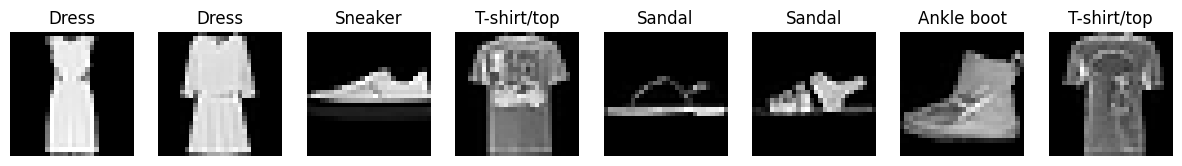

In [29]:
# -----------------------------
# 4. Visualize some training images
# -----------------------------

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

def plot_examples(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15,3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].squeeze(), cmap='gray')
        ax.set_title(f"{classes[labels[idx]]}")
        ax.axis('off')
    plt.show()

# Show images
plot_examples(images[:8], labels[:8])

In [16]:
# -----------------------------
# 5. Define a simple CNN (NO MAX POOL)
# -----------------------------
# Instead of max pooling, we use stride=2 in convolutions
# to downsample the feature maps.

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First conv: stride=2 reduces 28x28 -> 14x14
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        # Second conv: stride=2 reduces 14x14 -> 7x7
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)  # same size as before
        self.fc2 = nn.Linear(128, 10)      # 10 classes

    def forward(self, x):
        # Convolution + ReLU (downsampling done by stride)
        x = F.relu(self.conv1(x))   # -> 32 x 14 x 14
        x = F.relu(self.conv2(x))   # -> 64 x 7 x 7
        # Flatten for dense layers
        x = x.view(-1, 64*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = SimpleCNN()

In [17]:
# -----------------------------
# 6. Define loss function and optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()  # suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# -----------------------------
# 7. Training loop
# -----------------------------
epochs = 5
train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss/len(train_loader))
    train_acc.append(100 * correct / total)

    # Validation/Test
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss/len(test_loader))
    test_acc.append(100 * correct_test / total_test)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% - "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/5 - Train Loss: 0.3169, Train Acc: 88.30% - Test Loss: 0.3061, Test Acc: 88.87%


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2/5 - Train Loss: 0.2716, Train Acc: 89.92% - Test Loss: 0.2770, Test Acc: 89.93%


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/5 - Train Loss: 0.2372, Train Acc: 91.06% - Test Loss: 0.2674, Test Acc: 90.50%


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/5 - Train Loss: 0.2139, Train Acc: 92.03% - Test Loss: 0.2635, Test Acc: 90.60%


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/5 - Train Loss: 0.1919, Train Acc: 92.84% - Test Loss: 0.2486, Test Acc: 91.11%


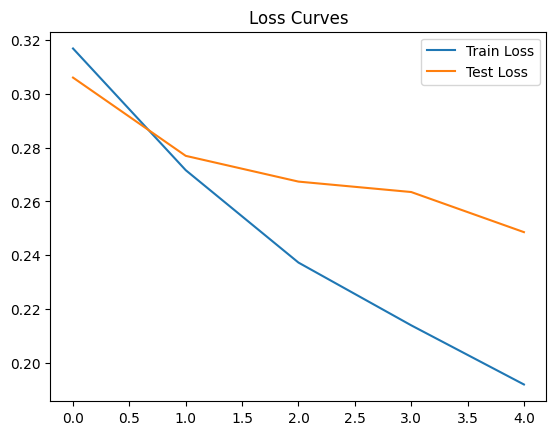

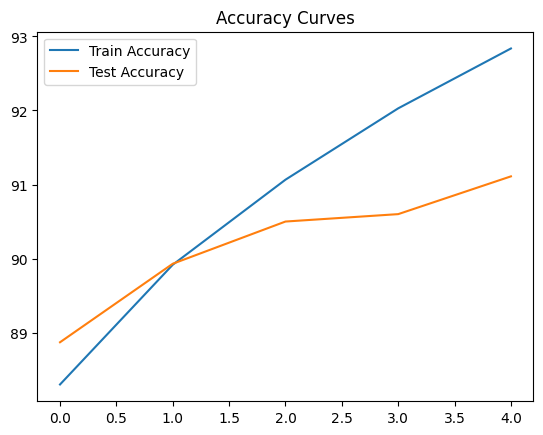

In [21]:
# -----------------------------
# 8. Plot loss and accuracy curves
# -----------------------------
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

In [22]:
# -----------------------------
# 9. Evaluate with precision, recall, F1
# -----------------------------
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.90      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.87      0.86      1000
       Dress       0.92      0.91      0.92      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.80      0.68      0.74      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



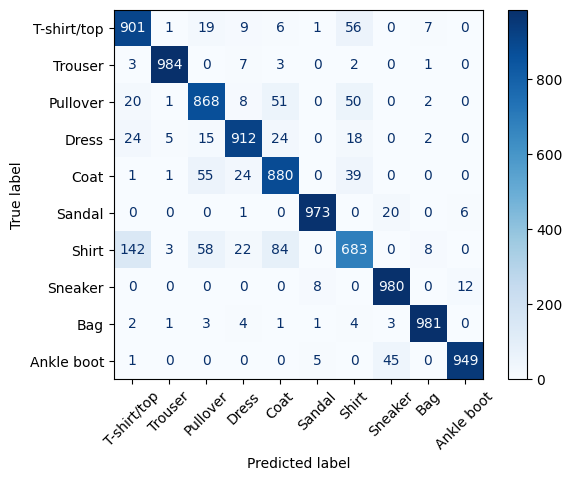

In [23]:
# -----------------------------
# 10. Confusion matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

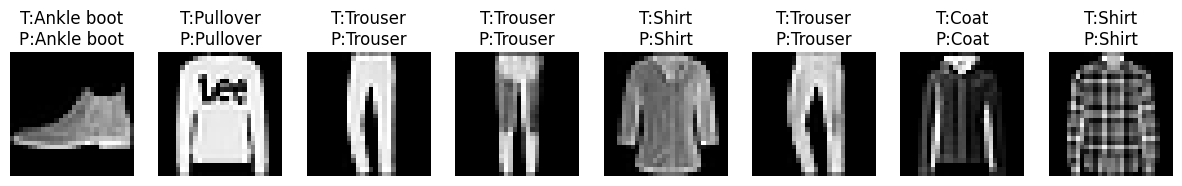

In [32]:
# -----------------------------
# 11. Visualize some predictions
# -----------------------------
def plot_predictions(images, labels, preds):
    fig, axes = plt.subplots(1, len(images), figsize=(15,3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].squeeze(), cmap='gray')
        ax.set_title(f"T:{classes[labels[idx]]}\nP:{classes[preds[idx]]}")
        ax.axis('off')
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)
_, preds = torch.max(outputs, 1)
plot_predictions(images[:8], labels[:8], preds[:8])

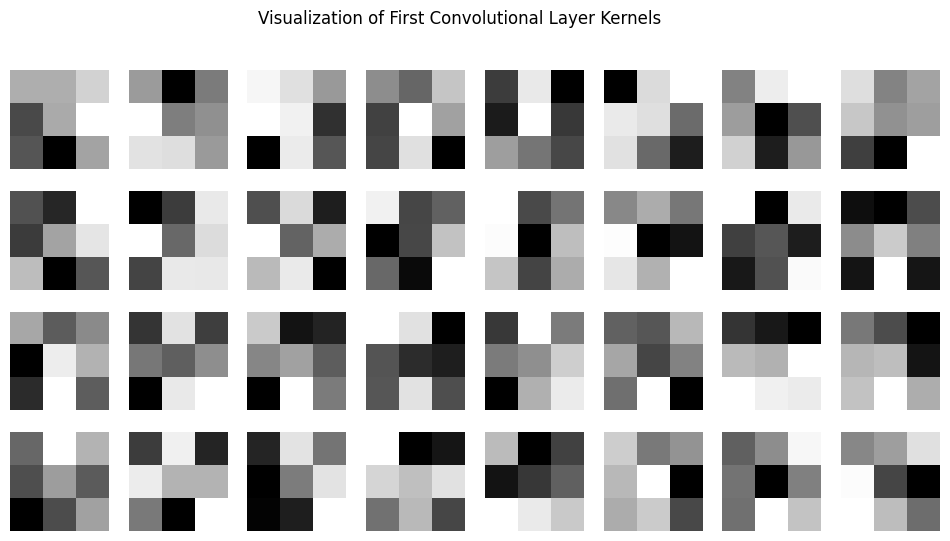

In [35]:
# -----------------------------
# 12. Visualize learned kernels
# -----------------------------
# Visualize first conv layer filters
with torch.no_grad():
    kernels = model.conv1.weight.clone()
    fig, axes = plt.subplots(4, 8, figsize=(12,6))
    for i, ax in enumerate(axes.flat):
        if i < kernels.shape[0]:
            ax.imshow(kernels[i][0].cpu(), cmap="gray")
            ax.axis("off")
    plt.suptitle("Visualization of First Convolutional Layer Kernels")
    plt.show()